총 10개의 데이터 처리 완료.


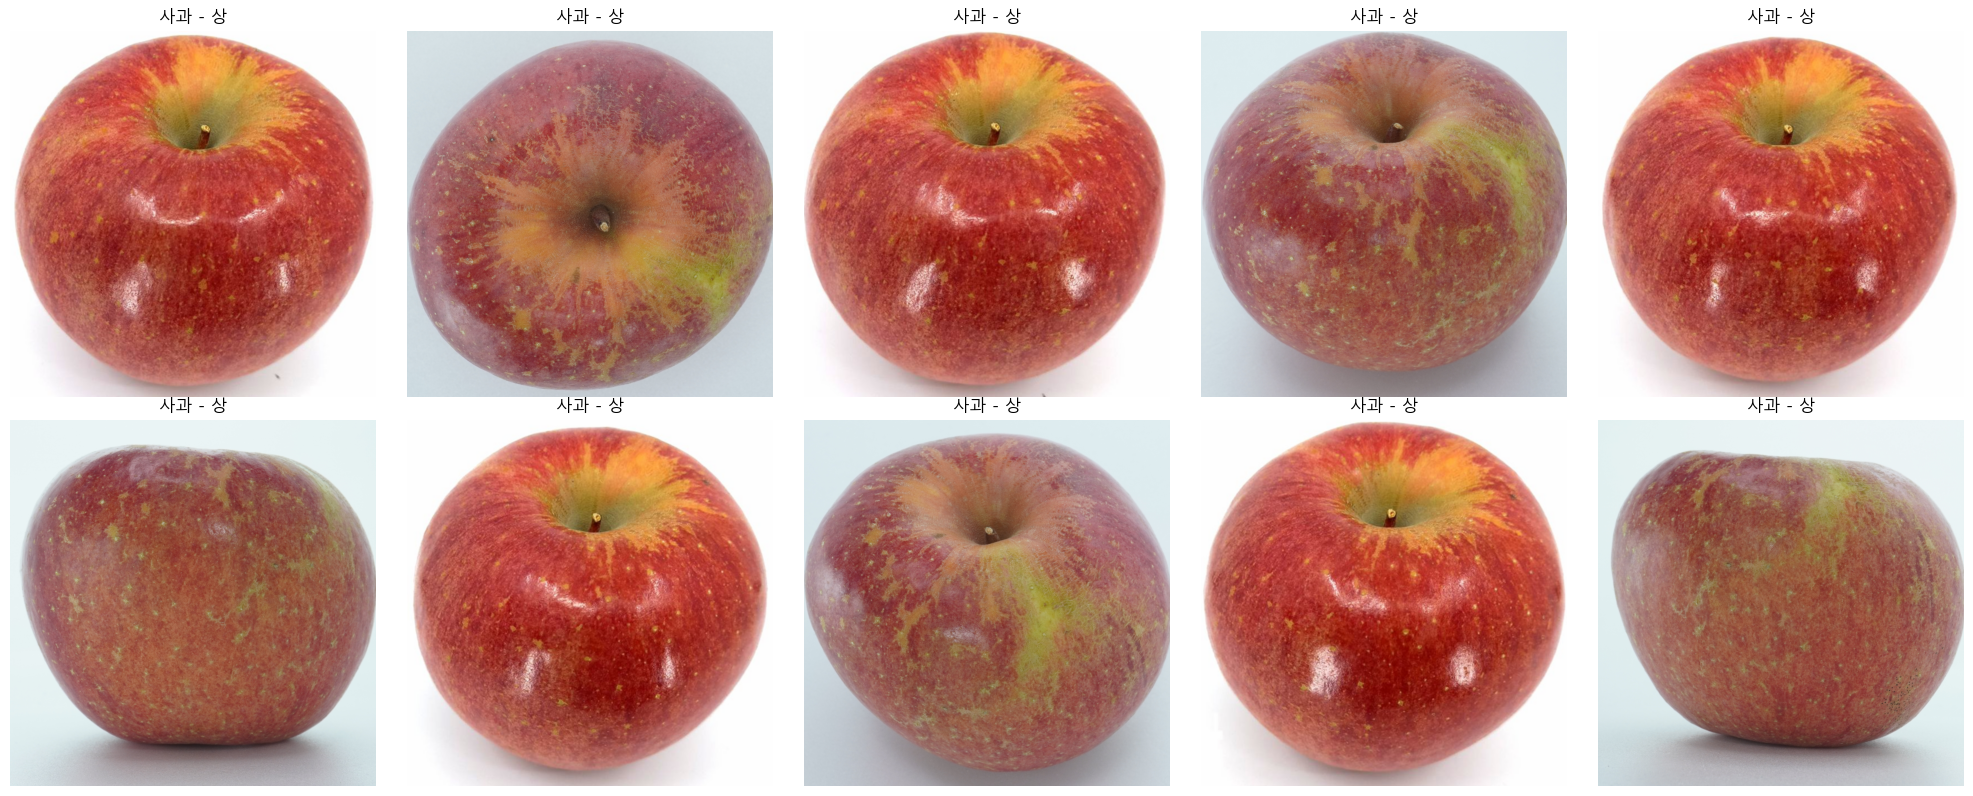

In [1]:
import os
import json
import cv2
import matplotlib.pyplot as plt 
import platform
import math

# 글씨체 지정
if platform.system() == 'Darwin': # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows': # Windows
    plt.rcParams['font.family'] = 'Malgun Gothic'

# (보너스) 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터가 있는 폴더 경로 설정
data_base_path = 'data/' 
json_folder_path = os.path.join(data_base_path, 'json')
image_folder_path = os.path.join(data_base_path, 'image') 

# 2. 전처리된 데이터를 저장할 리스트
processed_data = []

# 3. data 폴더 안의 모든 파일 목록 가져오기
try:
    file_list = os.listdir(json_folder_path)
except FileNotFoundError:
    print(f"'{json_folder_path}' 폴더를 찾을 수 없습니다.")
    file_list = []

# 4. JSON 파일 기준으로 반복 처리
for file_name in file_list:
    if file_name.endswith('.json'):
        json_path = os.path.join(json_folder_path, file_name)
        
        # 5. JSON 파일 읽기
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                info = json.load(f)
            
            # 6. JSON에서 필요한 정보 추출
            cate1 = info.get('cate1')
            cate3 = info.get('cate3')
            
            # 7. 대응하는 이미지 파일 경로 생성 (json -> png)
            # 예: apple_fuji_M_1-1_1TOP.json -> apple_fuji_M_1-1_1TOP.png
            img_file_name = file_name.replace('.json', '.png')
            img_path = os.path.join(image_folder_path, img_file_name)
            
            # 8. 이미지 파일 읽기
            if os.path.exists(img_path):
                # cv2.imread는 이미지를 BGR 순서로 읽어옵니다.
                image = cv2.imread(img_path)
                
                if image is not None:
                    # (선택) 이미지 전처리 (예: 리사이징, 정규화 등)
                    # image_resized = cv2.resize(image, (224, 224))
                    
                    # 9. 결과 저장
                    processed_data.append({
                        'image_path': img_path,
                        'image': image, # 실제 이미지 데이터
                        'cate1': cate1,
                        'cate3': cate3
                    })
                else:
                    print(f"이미지를 불러오는데 실패했습니다: {img_path}")
            else:
                print(f"대응하는 이미지 파일을 찾을 수 없습니다: {img_path}")
                
        except Exception as e:
            print(f"파일 처리 중 오류 발생 ({file_name}): {e}")

# 10. 결과 확인
print(f"총 {len(processed_data)}개의 데이터 처리 완료.")

# 한 줄에 표시할 이미지 개수
n_cols = 5
n_items = len(processed_data)

# 필요한 행(row)의 수 계산 (총 10개, 5개씩이므로 2줄)
n_rows = math.ceil(n_items / n_cols)

# 전체 도화지(figure) 및 subplot 격자 생성
# figsize=(가로크기, 세로크기) - 이미지 5개가 들어갈 수 있게 가로를 넉넉하게 줍니다.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))

# 11. 모든 데이터 샘플 확인
for i, sample in enumerate(processed_data):

    # 현재 이미지를 표시할 subplot 위치 계산
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] # 2x5 격자의 (row, col) 위치
    
    # Jupyter Notebook에서 이미지 출력
    # OpenCV (BGR) -> Matplotlib (RGB) 변환
    image_rgb = cv2.cvtColor(sample['image'], cv2.COLOR_BGR2RGB)
    ax.imshow(image_rgb)
    ax.set_title(f"{sample['cate1']} - {sample['cate3']}")
    ax.axis('off') # 축 숨기기

# 만약 데이터가 8개일 경우, 남는 2칸(9, 10번째)의 축을 숨김
for i in range(n_items, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [2]:
import torch
import os # os 모듈 추가

# 1. 로컬 yolov5 폴더 경로 설정
# 'test.ipynb'는 'fruits' 폴더 안에 있습니다.
# 'yolov5' 폴더는 상위 폴더('z-mini_project')에 있으므로
# 경로는 '../yolov5'가 됩니다.
local_yolov5_path = '../yolov5' 

# 2. 모델 로드 (source='local' 옵션 사용)
model = torch.hub.load(
    local_yolov5_path,    # 인터넷 대신 로컬 폴더 경로를 지정
    'yolov5s',            # 로드할 모델 이름
    source='local',       # ★★★ 'local' 소스를 사용한다고 명시 ★★★
    pretrained=True       # 미리 학습된 가중치 사용
)

# 3. 추론 실행 (이전과 동일)
sample_image = processed_data[0]['image']
result = model(sample_image)

# 4. 결과 출력 (이전과 동일)
print(result.pandas().xyxy[0])

YOLOv5  v7.0-446-ga53364d6 Python-3.10.19 torch-2.5.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
c:\Github\class\z-mini_project\fruits\../yolov5\models\common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, confidence, class, name]
Index: []
